# 等距特徵映射(Isometric Mapping)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from tqdm.notebook import tqdm
from random import choices

# MNIST Dataset

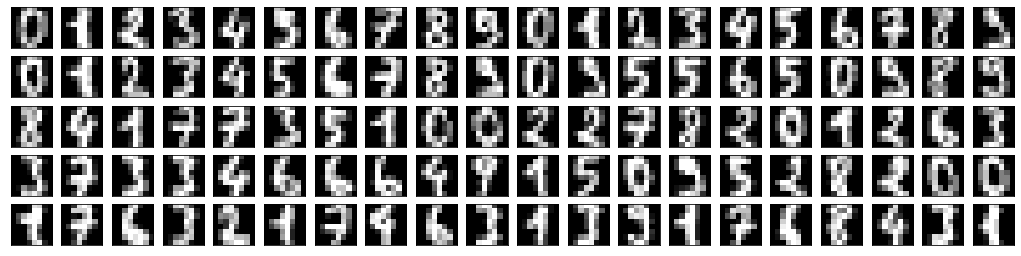

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X=digits.data/16
y=digits.target
plt.rcParams["figure.figsize"] = (18,18)
plt.gray() 
for i in range(100):
    plt.subplot(20, 20, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.show() 

# Cython

In [3]:
%load_ext Cython

# Ball Tree

In [4]:
def BuildSubtree(root,points,index,leaf_size,depth):
    if(depth==0):
        return
    centroid=np.mean(points[index,:],axis=0)
    root.centroid=centroid
    root.radius=np.max(np.sum((points[index,:]-centroid)**2,axis=1))**0.5
    farthest_point_1=np.argmax(np.sum((points[index,:]-centroid)**2,axis=1))
    real_index_1=index[farthest_point_1]
    distance_array_1=np.sum((points[index,:]-points[real_index_1,:])**2,axis=1)
    farthest_point_2=np.argmax(np.sum((points[index,:]-points[real_index_1,:])**2,axis=1))
    real_index_2=index[farthest_point_2]
    distance_array_2=np.sum((points[index,:]-points[real_index_2,:])**2,axis=1)
    BOOL=(distance_array_1<=distance_array_2)
    child1_index,child2_index=index[BOOL],index[~BOOL]
    root.index1,root.index2=real_index_1,real_index_2
    if(len(child1_index)<=leaf_size and len(child2_index)<=leaf_size):
        if(depth==1):
            print("tree is not complete")
        root.child1="end"
        root.child2="end"
    elif(len(child1_index)<=leaf_size):
        root.child1="end"
        root.child2=Tree()
        BuildSubtree(root.child2,points,child2_index,leaf_size,depth-1)
    elif(len(child2_index)<=leaf_size):
        root.child2="end"
        root.child1=Tree()
        BuildSubtree(root.child1,points,child1_index,leaf_size,depth-1)
    else:
        root.child1=Tree()
        BuildSubtree(root.child1,points,child1_index,leaf_size,depth-1)
        root.child2=Tree()
        BuildSubtree(root.child2,points,child2_index,leaf_size,depth-1)
    return

# k-Nearest Neighbor Search

In [5]:
def check(X,p,k,Q,index):
    if(np.sum((p-X[index,:])**2)<np.sum((p-X[Q[0],:])**2)):
        Q.append(index)
        Q=np.array(Q)
        Q=list(Q[np.argsort(-1*np.sum((p-X[Q,:])**2,axis=1))])
        if(len(Q)>k):    
            del Q[0]
    return Q

def kNN_search(X,p,k,Q,root):
    if(np.sqrt(np.sum((p-root.centroid)**2))-root.radius>=np.sqrt(np.sum((p-X[Q[0],:])**2))):
        return Q
    elif(root.child1=="end" and root.child2=="end"):
        Q=check(X,p,k,Q,root.index1)
        Q=check(X,p,k,Q,root.index2)
    elif(root.child1=="end"):
        Q=check(X,p,k,Q,root.index1)
        Q=kNN_search(X,p,k,Q,root.child2)
    elif(root.child2=="end"):
        Q=check(X,p,k,Q,root.index2)
        Q=kNN_search(X,p,k,Q,root.child1)
    else:
        Q=kNN_search(X,p,k,Q,root.child1)
        Q=kNN_search(X,p,k,Q,root.child2)
    return Q    

# Dijkstra's algorithm with Fibonacci stacks
The code is from Sci-Kit Learn Open Source Project: Shortest Path Algorithms

In [6]:
%%cython
import numpy as np
cimport numpy as np
from scipy.sparse import csr_matrix, isspmatrix, isspmatrix_csr
cimport cython
from libc.stdlib cimport malloc, free
np.import_array()
DTYPE = np.float64
ctypedef np.float64_t DTYPE_t
ITYPE = np.int32
ctypedef np.int32_t ITYPE_t
cdef struct FibonacciNode:
    unsigned int index
    unsigned int rank
    unsigned int state
    DTYPE_t val
    FibonacciNode* parent
    FibonacciNode* left_sibling
    FibonacciNode* right_sibling
    FibonacciNode* children
ctypedef FibonacciNode* pFibonacciNode
cdef struct FibonacciHeap:
    FibonacciNode* min_node
    pFibonacciNode[100] roots_by_rank 
cdef void insert_node(FibonacciHeap* heap,FibonacciNode* node):
    if heap.min_node:
        add_sibling(heap.min_node, node)
        if node.val < heap.min_node.val:
            heap.min_node = node
    else:
        heap.min_node = node
cdef void decrease_val(FibonacciHeap* heap,FibonacciNode* node,DTYPE_t newval):
    node.val = newval
    if node.parent and (node.parent.val >= newval):
        remove(node)
        insert_node(heap, node)
    elif heap.min_node.val > node.val:
        heap.min_node = node
cdef void link(FibonacciHeap* heap, FibonacciNode* node):
    cdef FibonacciNode *linknode
    cdef FibonacciNode *parent
    cdef FibonacciNode *child
    if heap.roots_by_rank[node.rank] == NULL:
        heap.roots_by_rank[node.rank] = node
    else:
        linknode = heap.roots_by_rank[node.rank]
        heap.roots_by_rank[node.rank] = NULL
        if node.val < linknode.val or node == heap.min_node:
            remove(linknode)
            add_child(node, linknode)
            link(heap, node)
        else:
            remove(node)
            add_child(linknode, node)
            link(heap, linknode)
cdef FibonacciNode* remove_min(FibonacciHeap* heap):
    cdef FibonacciNode *temp
    cdef FibonacciNode *temp_right
    cdef FibonacciNode *out
    cdef unsigned int i
    if heap.min_node.children:
        temp = leftmost_sibling(heap.min_node.children)
        temp_right = NULL
        while temp:
            temp_right = temp.right_sibling
            remove(temp)
            add_sibling(heap.min_node, temp)
            temp = temp_right
        heap.min_node.children = NULL
    temp = leftmost_sibling(heap.min_node)
    if temp == heap.min_node:
        if heap.min_node.right_sibling:
            temp = heap.min_node.right_sibling
        else:
            out = heap.min_node
            heap.min_node = NULL
            return out
    out = heap.min_node
    remove(heap.min_node)
    heap.min_node = temp
    for i from 0 <= i < 100:
        heap.roots_by_rank[i] = NULL
    while temp:
        if temp.val < heap.min_node.val:
            heap.min_node = temp
        temp_right = temp.right_sibling
        link(heap, temp)
        temp = temp_right
    return out
cdef void initialize_node(FibonacciNode* node,unsigned int index,DTYPE_t val=0):
    node.index = index
    node.val = val
    node.rank = 0
    node.state = 0 
    node.parent = NULL
    node.left_sibling = NULL
    node.right_sibling = NULL
    node.children = NULL
cdef FibonacciNode* rightmost_sibling(FibonacciNode* node):
    cdef FibonacciNode* temp = node
    while(temp.right_sibling):
        temp = temp.right_sibling
    return temp
cdef FibonacciNode* leftmost_sibling(FibonacciNode* node):
    cdef FibonacciNode* temp = node
    while(temp.left_sibling):
        temp = temp.left_sibling
    return temp
cdef void add_child(FibonacciNode* node, FibonacciNode* new_child):
    new_child.parent = node
    if node.children:
        add_sibling(node.children, new_child)
    else:
        node.children = new_child
        new_child.right_sibling = NULL
        new_child.left_sibling = NULL
        node.rank = 1
cdef void add_sibling(FibonacciNode* node, FibonacciNode* new_sibling):
    cdef FibonacciNode* temp = rightmost_sibling(node)
    temp.right_sibling = new_sibling
    new_sibling.left_sibling = temp
    new_sibling.right_sibling = NULL
    new_sibling.parent = node.parent
    if new_sibling.parent:
        new_sibling.parent.rank += 1
cdef void remove(FibonacciNode* node):
    if node.parent:
        node.parent.rank -= 1
        if node.left_sibling:
            node.parent.children = node.left_sibling
        elif node.right_sibling:
            node.parent.children = node.right_sibling
        else:
            node.parent.children = NULL
    if node.left_sibling:
        node.left_sibling.right_sibling = node.right_sibling
    if node.right_sibling:
        node.right_sibling.left_sibling = node.left_sibling
    node.left_sibling = NULL
    node.right_sibling = NULL
    node.parent = NULL
cdef void dijkstra_one_row(unsigned int i_node,
                    np.ndarray[ITYPE_t, ndim=1, mode='c'] neighbors1,
                    np.ndarray[DTYPE_t, ndim=1, mode='c'] distances1,
                    np.ndarray[ITYPE_t, ndim=1, mode='c'] indptr1,
                    np.ndarray[ITYPE_t, ndim=1, mode='c'] neighbors2,
                    np.ndarray[DTYPE_t, ndim=1, mode='c'] distances2,
                    np.ndarray[ITYPE_t, ndim=1, mode='c'] indptr2,
                    np.ndarray[DTYPE_t, ndim=2, mode='c'] graph,
                    FibonacciHeap* heap,
                    FibonacciNode* nodes):
    cdef unsigned int N = graph.shape[0]
    cdef unsigned int i_N
    cdef ITYPE_t i
    cdef FibonacciNode *v
    cdef FibonacciNode *current_neighbor
    cdef DTYPE_t dist
    for i_N in range(0, N):
        nodes[i_N].state = 0
        nodes[i_N].val = 0
    insert_node(heap, &nodes[i_node])
    while heap.min_node:
        v = remove_min(heap)
        v.state = 2 
        for i from indptr1[v.index] <= i < indptr1[v.index + 1]:
            current_neighbor = &nodes[neighbors1[i]]
            if current_neighbor.state != 2: 
                dist = distances1[i]
                if current_neighbor.state == 0: 
                    current_neighbor.state = 1   
                    current_neighbor.val = v.val + dist
                    insert_node(heap, current_neighbor)
                elif current_neighbor.val > v.val + dist:
                    decrease_val(heap, current_neighbor,v.val + dist)
        for i from indptr2[v.index] <= i < indptr2[v.index + 1]:
            current_neighbor = &nodes[neighbors2[i]]
            if current_neighbor.state != 2:      
                dist = distances2[i]
                if current_neighbor.state == 0: 
                    current_neighbor.state = 1   
                    current_neighbor.val = v.val + dist
                    insert_node(heap, current_neighbor)
                elif current_neighbor.val > v.val + dist:
                    decrease_val(heap, current_neighbor,v.val + dist)
        graph[i_node, v.index] = v.val
cdef np.ndarray dijkstra(dist_matrix,np.ndarray[DTYPE_t, ndim=2] graph):
    cdef unsigned int N = graph.shape[0]
    cdef unsigned int i
    cdef FibonacciHeap heap
    cdef FibonacciNode* nodes = <FibonacciNode*> malloc(N*sizeof(FibonacciNode))
    cdef np.ndarray distances, neighbors, indptr
    cdef np.ndarray distances2, neighbors2, indptr2
    if not isspmatrix_csr(dist_matrix):
        dist_matrix = csr_matrix(dist_matrix)
    distances = np.asarray(dist_matrix.data, dtype=DTYPE, order='C')
    neighbors = np.asarray(dist_matrix.indices, dtype=ITYPE, order='C')
    indptr = np.asarray(dist_matrix.indptr, dtype=ITYPE, order='C')
    for i from 0 <= i < N:
        initialize_node(&nodes[i], i)
    heap.min_node = NULL
    dist_matrix_T = dist_matrix.T.tocsr()
    distances2 = np.asarray(dist_matrix_T.data,dtype=DTYPE, order='C')
    neighbors2 = np.asarray(dist_matrix_T.indices,dtype=ITYPE, order='C')
    indptr2 = np.asarray(dist_matrix_T.indptr,dtype=ITYPE, order='C')
    for i from 0 <= i < N:
        dijkstra_one_row(i, neighbors, distances, indptr,
                             neighbors2, distances2, indptr2,
                             graph, &heap, nodes)
    free(nodes)
    return graph
def graph_shortest_path(dist_matrix):
    if not isspmatrix_csr(dist_matrix):
        dist_matrix = csr_matrix(dist_matrix)
    N = dist_matrix.shape[0]
    Nk = len(dist_matrix.data)
    graph = np.zeros((N, N), dtype=DTYPE, order='C')
    dijkstra(dist_matrix, graph)
    return graph

# Building Tree and Nearest Neighbor

In [7]:
class Tree:
    def __init__(self):
        self.child1=None
        self.child2=None
        self.radius=None
        self.centroid=None
        self.index1=None
        self.index2=None
root=Tree()
N,M=X.shape
Index=np.array(range(0,N))
BuildSubtree(root,X,Index,1,30)
Mat=np.zeros((N,N))
for i in tqdm(range(0,N)):
    k=5
    Q=[]
    while(len(Q)!=k):
        Q=list(np.random.randint(N,size=1))
        Q=kNN_search(X,X[i,:],k,Q,root)
    Mat[i,Q]=np.sqrt(np.sum((X[Q,:]-X[i,:])**2,axis=1))
print(Mat)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Compute Geodesic distance Matrix

In [8]:
GDM=graph_shortest_path(Mat)
GDM

array([[ 0.        , 16.26895081, 21.61670988, ..., 16.40061999,
        20.16456508, 13.31780818],
       [16.26895081,  0.        ,  6.60640031, ...,  4.72122693,
        13.83241077,  5.83087649],
       [21.61670988,  6.60640031,  0.        , ...,  7.92890669,
        14.54806513,  8.29890171],
       ...,
       [16.40061999,  4.72122693,  7.92890669, ...,  0.        ,
         9.11118384,  3.08281182],
       [20.16456508, 13.83241077, 14.54806513, ...,  9.11118384,
         0.        , 11.67920617],
       [13.31780818,  5.83087649,  8.29890171, ...,  3.08281182,
        11.67920617,  0.        ]])

# Dimensional Reduction

In [9]:
C=np.diag(np.ones(N))-np.outer(np.ones(N),np.ones(N))/N
B=np.dot(np.dot(C,GDM**2),C)
A,V=np.linalg.eig(B)
idx=np.argsort(A)
X_sub=np.dot(V[:,idx[:2]],np.diag(A[idx[:2]]))

# Plot

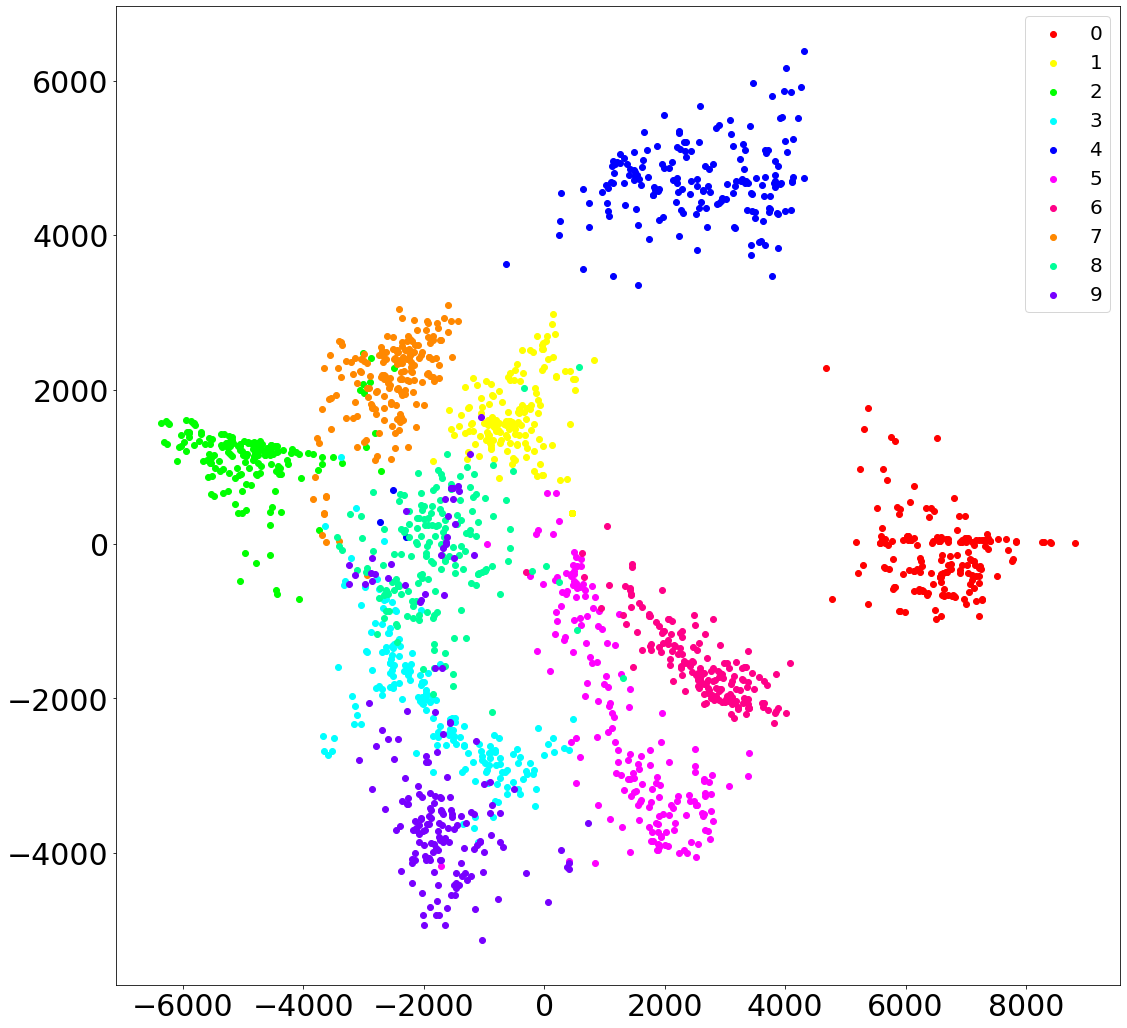

In [10]:
color=["#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF",
       "#FF00FF","#FF0088","#FF8800","#00FF99","#7700FF"]
plt.rcParams["figure.figsize"] = (18,18)
for i in range(0,10):
    BOOL=(y==i)
    plt.scatter(X_sub[BOOL,0],X_sub[BOOL,1],c=color[i],label=i)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
plt.show()